In [1]:
'''
Import the modules that will be used
'''

import sys
import warnings
from distutils.version import LooseVersion

import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import network
import utils

%matplotlib inline

In [59]:
'''
Define the neural network that was used and define hyper-parameters.
These are needed to infer from the saved network checkpoint
'''

tf.reset_default_graph()

datadir =  '/media/cjw/Data/cyto/mmFromTifs/'
#datadir =  '/media/cjw/Data/cyto/ChannelOne/'

#cp_dir = '/home/cjw/disk2cjw/PythonLib/cjwdeeplearning/autoencoder/checkpoint-2018-03-19-11-19-18/'
cp_dir = "/media/cjw/Data/cyto/Checkpoints/2018-04-12-Channel-0/checkpoint-2018-04-12-10-43-32/"
aemeta = 'autoencoder-64x-28020.meta'
#checkpoint-2018-03-02-16-31-42/'
p_width = 32
p_height = 32
p_nchannels = 1
p_channels = [0]
p_nepochs = 60
p_batchsize = 64
p_learning_rate = 0.0002  #.00005
p_restore = False
p_latent_size = 64 #128 + 64
p_droprate = 0.95
p_stdev = .04

enc_sizes = [(64, 3), (128, 3), (256,3)] #, (512,3)] #, (64, 3), (128,3)] #, (32, 3), (64, 3)]
dec_sizes = list(reversed(enc_sizes))
images = tf.placeholder(tf.float32, (None, p_height, p_width, p_nchannels))
z = tf.placeholder(tf.float32, (None, p_latent_size))

enc = network.encoder(images, p_latent_size, droprate=p_droprate, is_train=False,
                      nfilters=enc_sizes)
sdd = network.decoder(enc, nchannels=p_nchannels, width=p_width, droprate=p_droprate,
                      is_train=False, nfilters=dec_sizes)

loss, _, _ = network.ae_loss(images, sdd)

opt = network.model_opt(loss, p_learning_rate)

saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph(cp_dir + aemeta) #autoencoder-64x-18660.meta')
saver.restore(sess, tf.train.latest_checkpoint(cp_dir + ''))


Encoder False
[<tf.Tensor 'Placeholder:0' shape=(?, 32, 32, 1) dtype=float32>, <tf.Tensor 'Maximum:0' shape=(?, 16, 16, 64) dtype=float32>, <tf.Tensor 'Maximum_1:0' shape=(?, 8, 8, 128) dtype=float32>, <tf.Tensor 'Maximum_2:0' shape=(?, 4, 4, 256) dtype=float32>] Tensor("latent_space/BiasAdd:0", shape=(?, 64), dtype=float32)
isize:  4 32
[<tf.Tensor 'Maximum_3:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'Reshape:0' shape=(?, 4, 4, 256) dtype=float32>, <tf.Tensor 'Maximum_4:0' shape=(?, 8, 8, 128) dtype=float32>, <tf.Tensor 'Maximum_5:0' shape=(?, 16, 16, 64) dtype=float32>] Tensor("decoder_out/BiasAdd:0", shape=(?, 32, 32, 1), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /home/cjw/disk2cjw/Data/cyto/Checkpoints/2018-04-12-Channel-0/checkpoint-2018-04-12-10-43-32/autoencoder-64x-28020


In [60]:

#datadir = "/home/cjw/disk2cjw/Data/yeast/"
mmfiles = utils.list_mmfiles(datadir)
print(mmfiles)

mmdict = dict()

n_all_images = 0
for mmfilename in mmfiles:
#mmfilename = datadir + "Fish6_15_cjw_mean_zero.mm"
#mmfilename = datadir + "mmplate15-1.mm"
    mmheader = np.memmap(mmfilename, dtype="int32", mode='r',
                    shape=(4,))

    header_shape = mmheader.shape
    print(header_shape, mmheader)
    xshape = [mmheader[0], mmheader[1], mmheader[2], mmheader[3]]
    xshape = tuple(xshape)
    del mmheader
    n_all_images += xshape[0]
    
    m3 = np.memmap(mmfilename, dtype='float32', offset=128,
              mode='r', shape=xshape)
    key = mmfilename.split("/")[-1]
    mmdict[key] = m3

print(n_all_images)
mmdict.keys()

['/media/cjw/Data/cyto/mmFromTifs/Fish6_Untreated.mm', '/media/cjw/Data/cyto/mmFromTifs/Fish6_ICE.mm', '/media/cjw/Data/cyto/mmFromTifs/Fish6_CCB.mm']
(4,) [10000    64    64     5]
(4,) [10000    64    64     5]
(4,) [10000    64    64     5]
30000


dict_keys(['Fish6_Untreated.mm', 'Fish6_ICE.mm', 'Fish6_CCB.mm'])

In [61]:
n = xshape[0]
all_ids =  range(n_all_images)
idx = 0
dataframes = list()
for key in mmdict.keys():
    mm = mmdict[key]
    n = mm.shape[0]
    #print(n)
    file = n*[key[0:-3]]
    fid = range(n)
    mmfile = n*[key]
    plate = n*[0]
    row = n*[0]
    column = n*[0]
    field = n*[0]
    yc = n*[32]
    xc = n*[32]
    well = n*[0]
    ids = all_ids[idx:idx + n]
    idx += n
    xdf = pd.DataFrame({'id':ids, 'fid':fid, 'file':file, 'mmfile':mmfile, 'plate':plate,
                     'row':row, 'column':column, 'field':field,
                      'yc':yc, 'xc':xc, 'well':well})

    dataframes.append(xdf)

trts = list()
runs = list()
alldf = pd.concat(dataframes, ignore_index=True)

for row in range(len(alldf)):
    file = alldf.iloc[row]['file']
    if '_ice' in file.lower():
        treatment = 'ice'
    elif '_ccb'in file.lower():
        treatment = 'ccb'
    else:
        treatment = "untreated"
    trts.append(treatment)
    runs.append(file[0:5])

alldf['treatment'] = trts
alldf['run'] = runs
df = alldf.sample(frac=.40)
df = df.reset_index()
print(len(df))
df.tail()

12000


,index,column,fid,field,file,id,mmfile,plate,row,well,xc,yc,treatment,run
11995,15659,0,5659,0,Fish6_ICE,15659,Fish6_ICE.mm,0,0,0,32,32,ice,Fish6
11996,21667,0,1667,0,Fish6_CCB,21667,Fish6_CCB.mm,0,0,0,32,32,ccb,Fish6
11997,3281,0,3281,0,Fish6_Untreated,3281,Fish6_Untreated.mm,0,0,0,32,32,untreated,Fish6
11998,17876,0,7876,0,Fish6_ICE,17876,Fish6_ICE.mm,0,0,0,32,32,ice,Fish6
11999,29261,0,9261,0,Fish6_CCB,29261,Fish6_CCB.mm,0,0,0,32,32,ccb,Fish6


In [62]:
sns.set_style("whitegrid", {'axes.grid' : False})

0.29659 0.525931


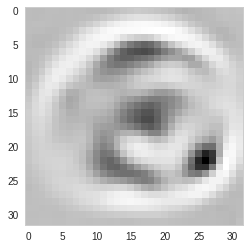

In [63]:
m1 = mmdict['Fish6_Untreated.mm']

bx = m1[34,16:48,16:48,0]
bx = np.expand_dims(bx, axis=0)
bx = np.expand_dims(bx, axis=-1)
bx.shape
bxe = sess.run(enc, feed_dict={images:bx})
#plt.plot(bxe[0])
bxd = sess.run(sdd, feed_dict={enc:bxe})
plt.imshow(bxd.squeeze())
print(np.mean(bxd),np.max(bxd))

(12000, 64) (12000, 32, 32, 1)
0.0221739131957 0.975924313068


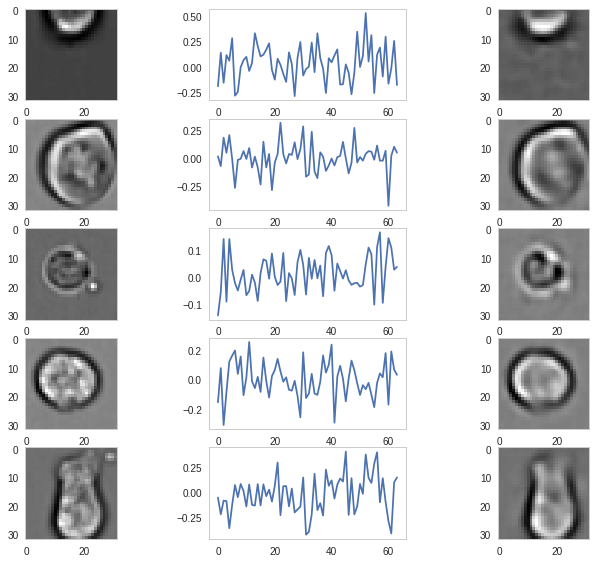

In [64]:
'''Read the images, display image, encode and show latent space, show decoded'''

vv = utils.getWell(mmdict,
                    df, p_width, 0, 0, p_nchannels, channels=p_channels)

nvv = len(vv)
offloc = 0
offstep = 1000
offnext = offloc + offstep
xhe = np.zeros((nvv, p_latent_size))
xdd = np.zeros((nvv, p_width, p_height, p_nchannels))
while offloc < nvv:
    #print(offloc, offnext)
    xhe[offloc:offnext] = sess.run(enc, feed_dict={images:vv[offloc:offnext]})
    xdd[offloc:offnext] = sess.run(sdd, feed_dict={enc:xhe[offloc:offnext]})
    offloc = offnext
    offnext += offstep
    if offnext > nvv:
        offnext = nvv
        
f = plt.figure(figsize=(12, 40))
print(xhe.shape, xdd.shape)
print(np.amin(vv),np.amax(vv))
for i in range(5):
    ix = np.random.randint(0, len(vv))
    #print(ix)
    plt.subplot(20,3,i*3 + 1)
    plt.imshow(vv[ix,:,:,0], cmap='gray')
    plt.subplot(20,3,i*3 + 2)
    plt.plot(xhe[ix])
    plt.subplot(20,3,i*3 + 3)
    plt.imshow(xdd[ix,:,:,0], cmap='gray')
   

In [65]:
'''Encode the images with the trained network and store the latent spaces in an array'''

dv = {0:(0,0)}
dimages = dict()
counter = 0
one = 0
for k in dv.keys():
    i, j = dv[k]
    print(i, j)
    r = i + 1
    cm = j + 1
    try:
        k = vv #utils.getWell(mmdict,df, width, 0, 0, nchannels, channels=[0])
        print(len(k))
    except:
        print("Oh no!!")
        continue
    hek = xhe #sess.run(enc, feed_dict={images:k})
    print('hek', hek.shape)
    dimages[counter] = k
    if one == 0:
        one = 1
        g = hek
        colors = np.zeros(k.shape[0])
        counter += 1
        print(i, j, g.shape, hek.shape)
    else:
        print(i, j, g.shape, hek.shape)
        g = np.concatenate((g,hek))
        colors = np.concatenate((colors, counter + np.zeros(k.shape[0])))
        counter += 1

g_all = g
g_all.shape

0 0
12000
hek (12000, 64)
0 0 (12000, 64) (12000, 64)


(12000, 64)

In [66]:
''' Create some colors for display later on'''

from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
clist = [(.2,.2,.2),
         (172/255,25/255,210/255),
         (255/255, 165./255, 0),
         (44/255,25/255,210/255),
         (134/255, 165./255, 56/255),
         (26/255,188/255,255/255),
         (188/255,255/255, 26/255),
         (1, 0,0), (0,1,0), (0,0,1)]

mycmap = LinearSegmentedColormap.from_list(
        'mycmap', clist, N=len(clist))

bounds = np.linspace(0, len(clist), len(clist) + 1)
norm = mpl.colors.BoundaryNorm(bounds, mycmap.N)
print(bounds, mycmap.N)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.] 10


In [88]:
'''Do PCA on the latent space features'''

from sklearn.decomposition import PCA
pca = PCA(n_components=8, svd_solver='arpack', whiten=True, copy=True)
gfit = pca.fit_transform(g_all)
print(gfit.shape)
print(pca.explained_variance_)
print(pca.components_.shape)


(12000, 8)
[ 0.10918967  0.06887436  0.05345918  0.04617784  0.03984011  0.03751832
  0.03562692  0.03418455]
(8, 64)


In [94]:
'''
Do clustering on the latent space features
find eight cluster for K-Means and Allomerative Clustering
'''


nclust = 8
from sklearn import cluster
agc = None
km = cluster.KMeans(n_clusters=nclust).fit_predict(g_all)
agc = cluster.AgglomerativeClustering(n_clusters=nclust, affinity='euclidean', linkage="ward").fit_predict(g_all)


###  Show results of clustering using K-Means

Each row is a cluster found using the K-Means algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

In [90]:
df['km'] = km
df['agc'] = agc

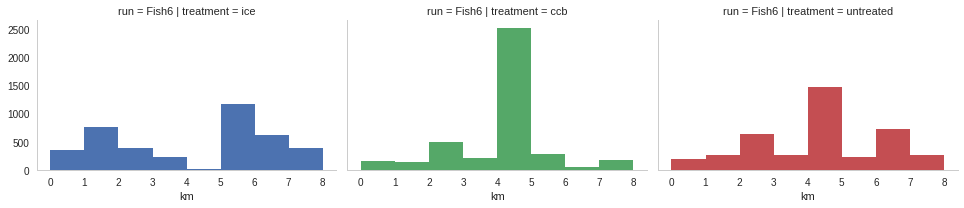

In [91]:
fg = sns.FacetGrid(df, col='treatment', row='run', hue='treatment', size=3, aspect=1.5)
fg = fg.map(plt.hist, 'km', bins=range(nclust + 1))

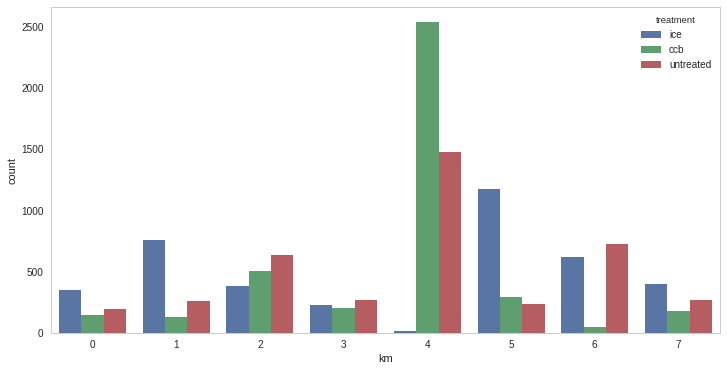

In [140]:

fig = plt.figure(figsize=(12,6))
cp = sns.countplot(x='km', hue='treatment', data=df)


(12000, 32, 32, 1)


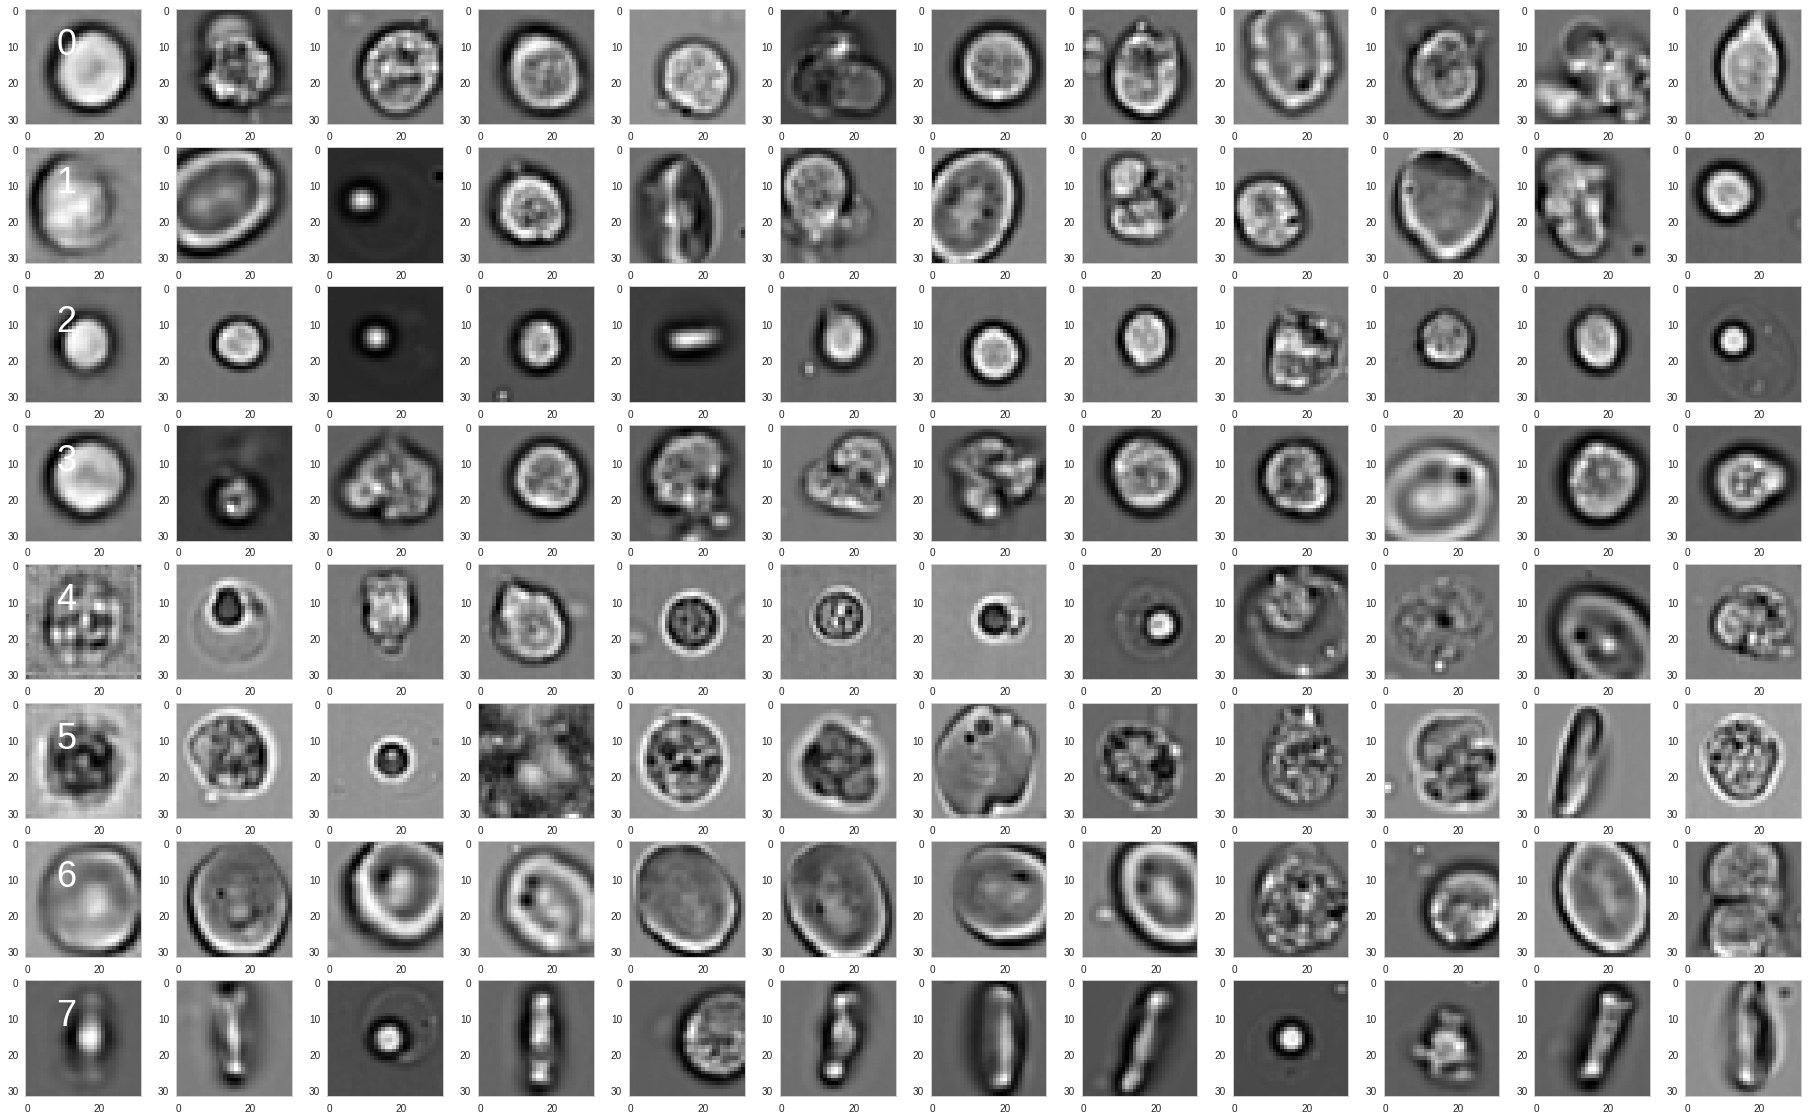

In [93]:
ximages = vv
print(ximages.shape)

nk = nclust
plt.figure(figsize=(32, 2.5*nk))

counter = 1
shift = 0
for k in range(nk):
    #row = ximages[km == k]
    rowdf = df[df['km'] == k]
    inum = list(rowdf.index)
    gk = g_all[km == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
    plt.subplot(nk, 12, counter)
    plt.imshow(resav.squeeze(), cmap='gray')
    plt.text(8, 12,str(k), fontsize=36, color='white')
    counter += 1
    for i in range(11):
        plt.subplot(nk, 12, counter)
        counter += 1
        try:
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            #plt.text(5, 5,str(df.iloc[rnd]['id']), fontsize=20, color='black')
            #print(rnd, df.iloc[rnd]['mmfile'])
        except:
            plt.imshow(np.zeros((64,64)))

###  Show results of clustering using Agglomerative Clustering

Each row is a cluster found using the [Agglomerative Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

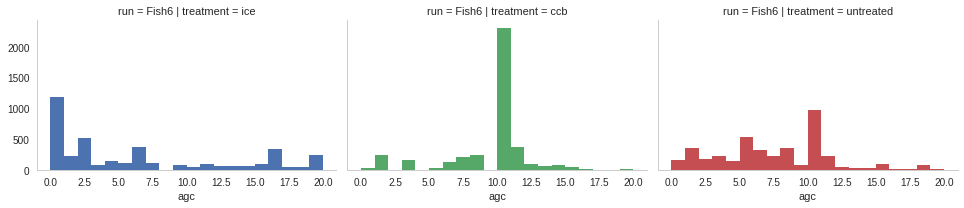

In [73]:
df['agc'] = agc
fg = sns.FacetGrid(df, col='treatment', row='run', hue='treatment', size=3, aspect=1.5)
fg = fg.map(plt.hist, 'agc', bins=range(nclust + 1))

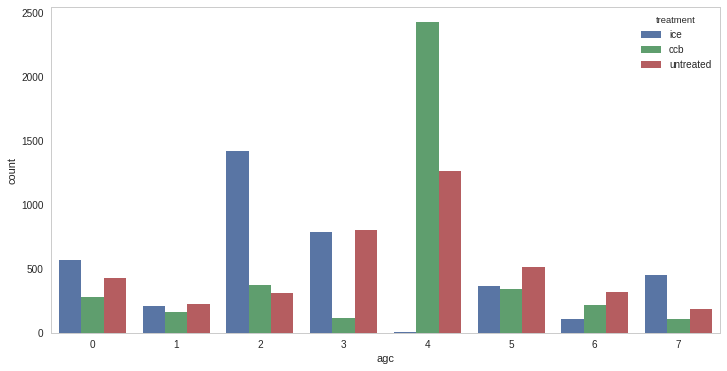

In [141]:

fig = plt.figure(figsize=(12,6))
cp = sns.countplot(x='agc', hue='treatment', data=df)


0 1277
1 599
2 2099
3 1712
4 3694
5 1223
6 645
7 751


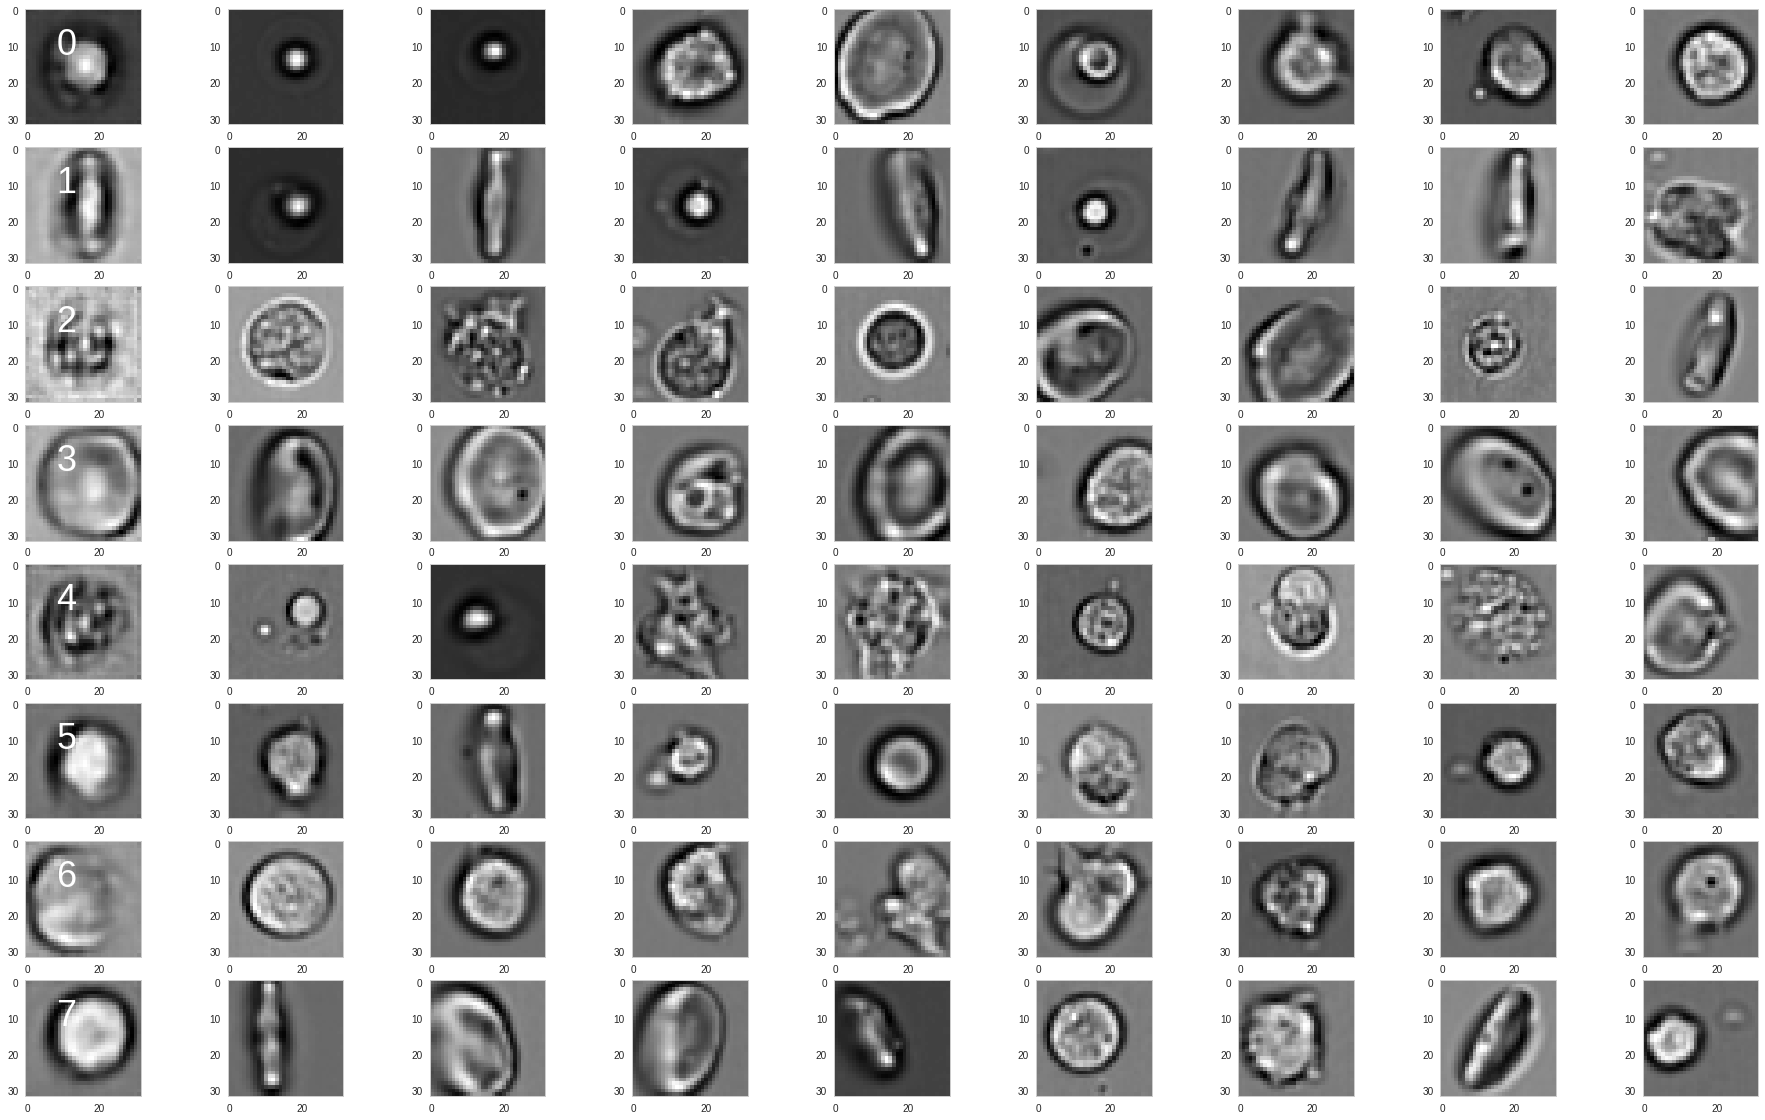

In [142]:
nk = nclust
plt.figure(figsize=(32, 2.5*nk))

counter = 1
shift = 0
for k in range(nk):
    #row = ximages[agc == k]
    rowdf = df[df['agc'] == k]
    inum = list(rowdf.index)
    print(k, len(rowdf))
    gk = g_all[agc == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
    plt.subplot(nk, 9, counter)
    plt.imshow(resav.squeeze(), cmap='gray')
    plt.text(8, 12,str(k), fontsize=36, color='white')
    counter += 1
    for i in range(8):
        plt.subplot(nk, 9, counter)
        counter += 1
        try:
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            #plt.text(8, 12,str(rnd), fontsize=24, color='white')
        except:
            plt.imshow(np.zeros((64,64)))

-------------------------------------------------------------------------

(1379, 32, 32, 1)


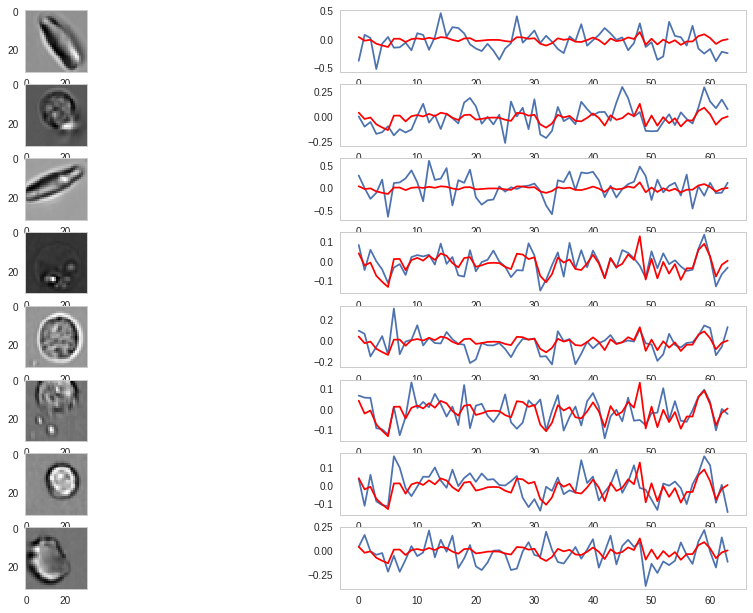

In [81]:
tn = 0
images4 = ximages[agc == tn]
g4 = g_all[agc == tn]
plt.figure(figsize=(16,12))
print(images4.shape)

gtest = np.mean(g4, axis=0)
gtest = np.expand_dims(gtest.squeeze(), axis=0)
res = sess.run(sdd, feed_dict={enc:gtest})

gav = np.mean(g_all, axis=0)
gav = np.expand_dims(gav.squeeze(), axis=0)
resav = sess.run(sdd, feed_dict={enc:gav})

ppi = 0
for i in range(8):
    ix = np.random.randint(0, len(g4))
    plt.subplot(9,2,i*2 + 1)
    plt.imshow(images4[ix,:,:,0], cmap='gray')
    plt.subplot(9,2, i*2 + 2)
    plt.plot(g4[ix,:])
    plt.plot(gtest.squeeze(), c='r')
    ppi += 2

#plt.subplot(9,2, ppi+ 1 )
#plt.imshow(res.squeeze())
#plt.subplot(9,2, ppi + 2)
#plt.plot(gtest.squeeze())
#plt.subplot(6,2, ppi + 3)
#plt.imshow(resav.squeeze())
#plt.subplot(6,2, ppi + 4)
#plt.plot(gav.squeeze())


In [66]:
from sklearn.manifold import TSNE
print(g_all.shape)
geez = list()
ceez = list()
cindex = 0
for i in (2,7):
    gna = g_all[agc == i]
    ca = cindex #np.array(clist[cindex])
    cna = np.repeat([i], gna.shape[0], axis=0)
    geez.append(gna)
    ceez.append(cna)
    cindex += 1
# c3 = gn3.shape[0]*(1, 0, 0)
# c6 = gn3.shape[0]*(0, 1, 0)
# c10 = gn3.shape[0]*(0, 0, 1)
gn = np.concatenate(geez)
cn = np.concatenate(ceez)
# cn = np.concatenate((c3, c6, c10))
print(gn.shape)
g_emb = TSNE(n_components=2,perplexity=50, learning_rate=1000).fit_transform(gn.astype(np.float64))
print(g_emb.shape)

(14400, 128)
(961, 128)
(961, 2)


In [103]:
af = cluster.AffinityPropagation(preference=-50).fit(g_all)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)



Estimated number of clusters: 20


NameError: name 'metrics' is not defined

In [107]:
from sklearn import metrics
print('Estimated number of clusters: %d' % n_clusters_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# #print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(g_all, labels, metric='sqeuclidean'))


Estimated number of clusters: 20
Silhouette Coefficient: -0.021


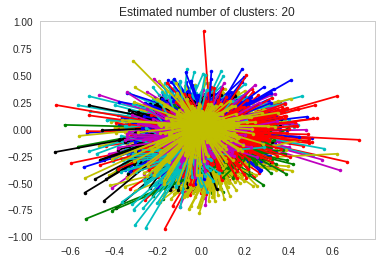

In [109]:
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

X = g_all
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

(328, 32, 32, 1)


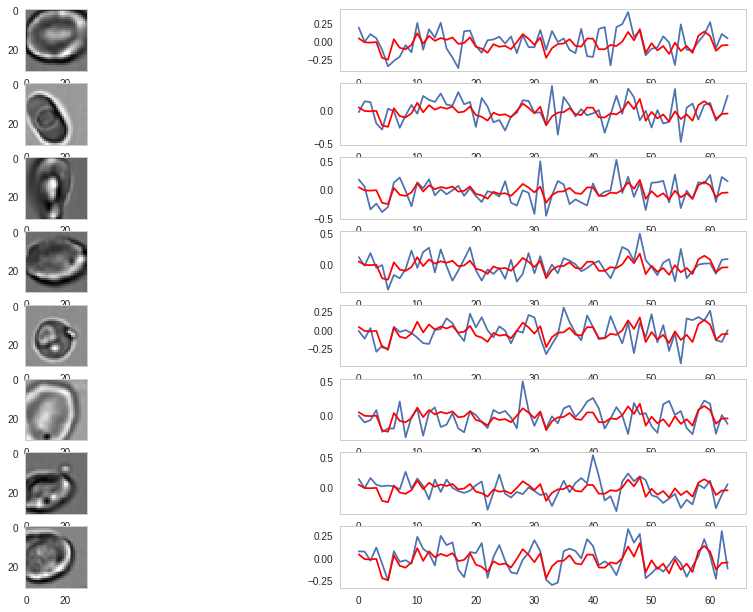

In [125]:
tn = 14
images4 = ximages[labels == tn]
g4 = g_all[labels == tn]
plt.figure(figsize=(16,12))
print(images4.shape)

gtest = np.mean(g4, axis=0)
gtest = np.expand_dims(gtest.squeeze(), axis=0)
res = sess.run(sdd, feed_dict={enc:gtest})

gav = np.mean(g_all, axis=0)
gav = np.expand_dims(gav.squeeze(), axis=0)
resav = sess.run(sdd, feed_dict={enc:gav})

ppi = 0
for i in range(8):
    ix = np.random.randint(0, len(g4))
    plt.subplot(9,2,i*2 + 1)
    plt.imshow(images4[ix,:,:,0], cmap='gray')
    plt.subplot(9,2, i*2 + 2)
    plt.plot(g4[ix,:])
    plt.plot(gtest.squeeze(), c='r')
    ppi += 2

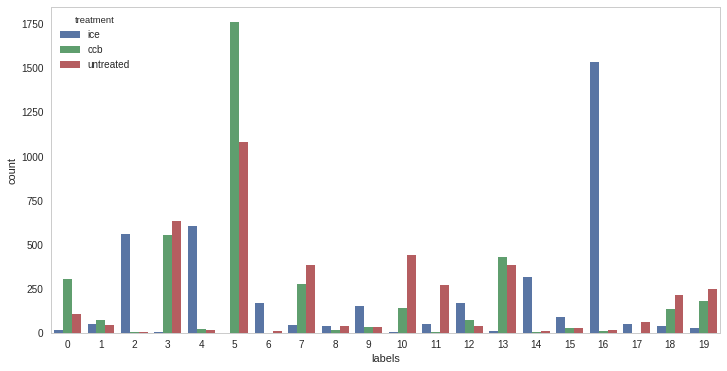

In [127]:
df['labels'] = labels
fig = plt.figure(figsize=(12,6))
cp = sns.countplot(x='labels', hue='treatment', data=df)

0 425 1
1 164 10
2 562 19
3 1190 28
4 645 37
5 2835 46
6 176 55
7 704 64
8 90 73
9 214 82
10 582 91
11 326 100
12 279 109
13 827 118
14 328 127
15 143 136
16 1557 145
17 115 154
18 385 163
19 453 172


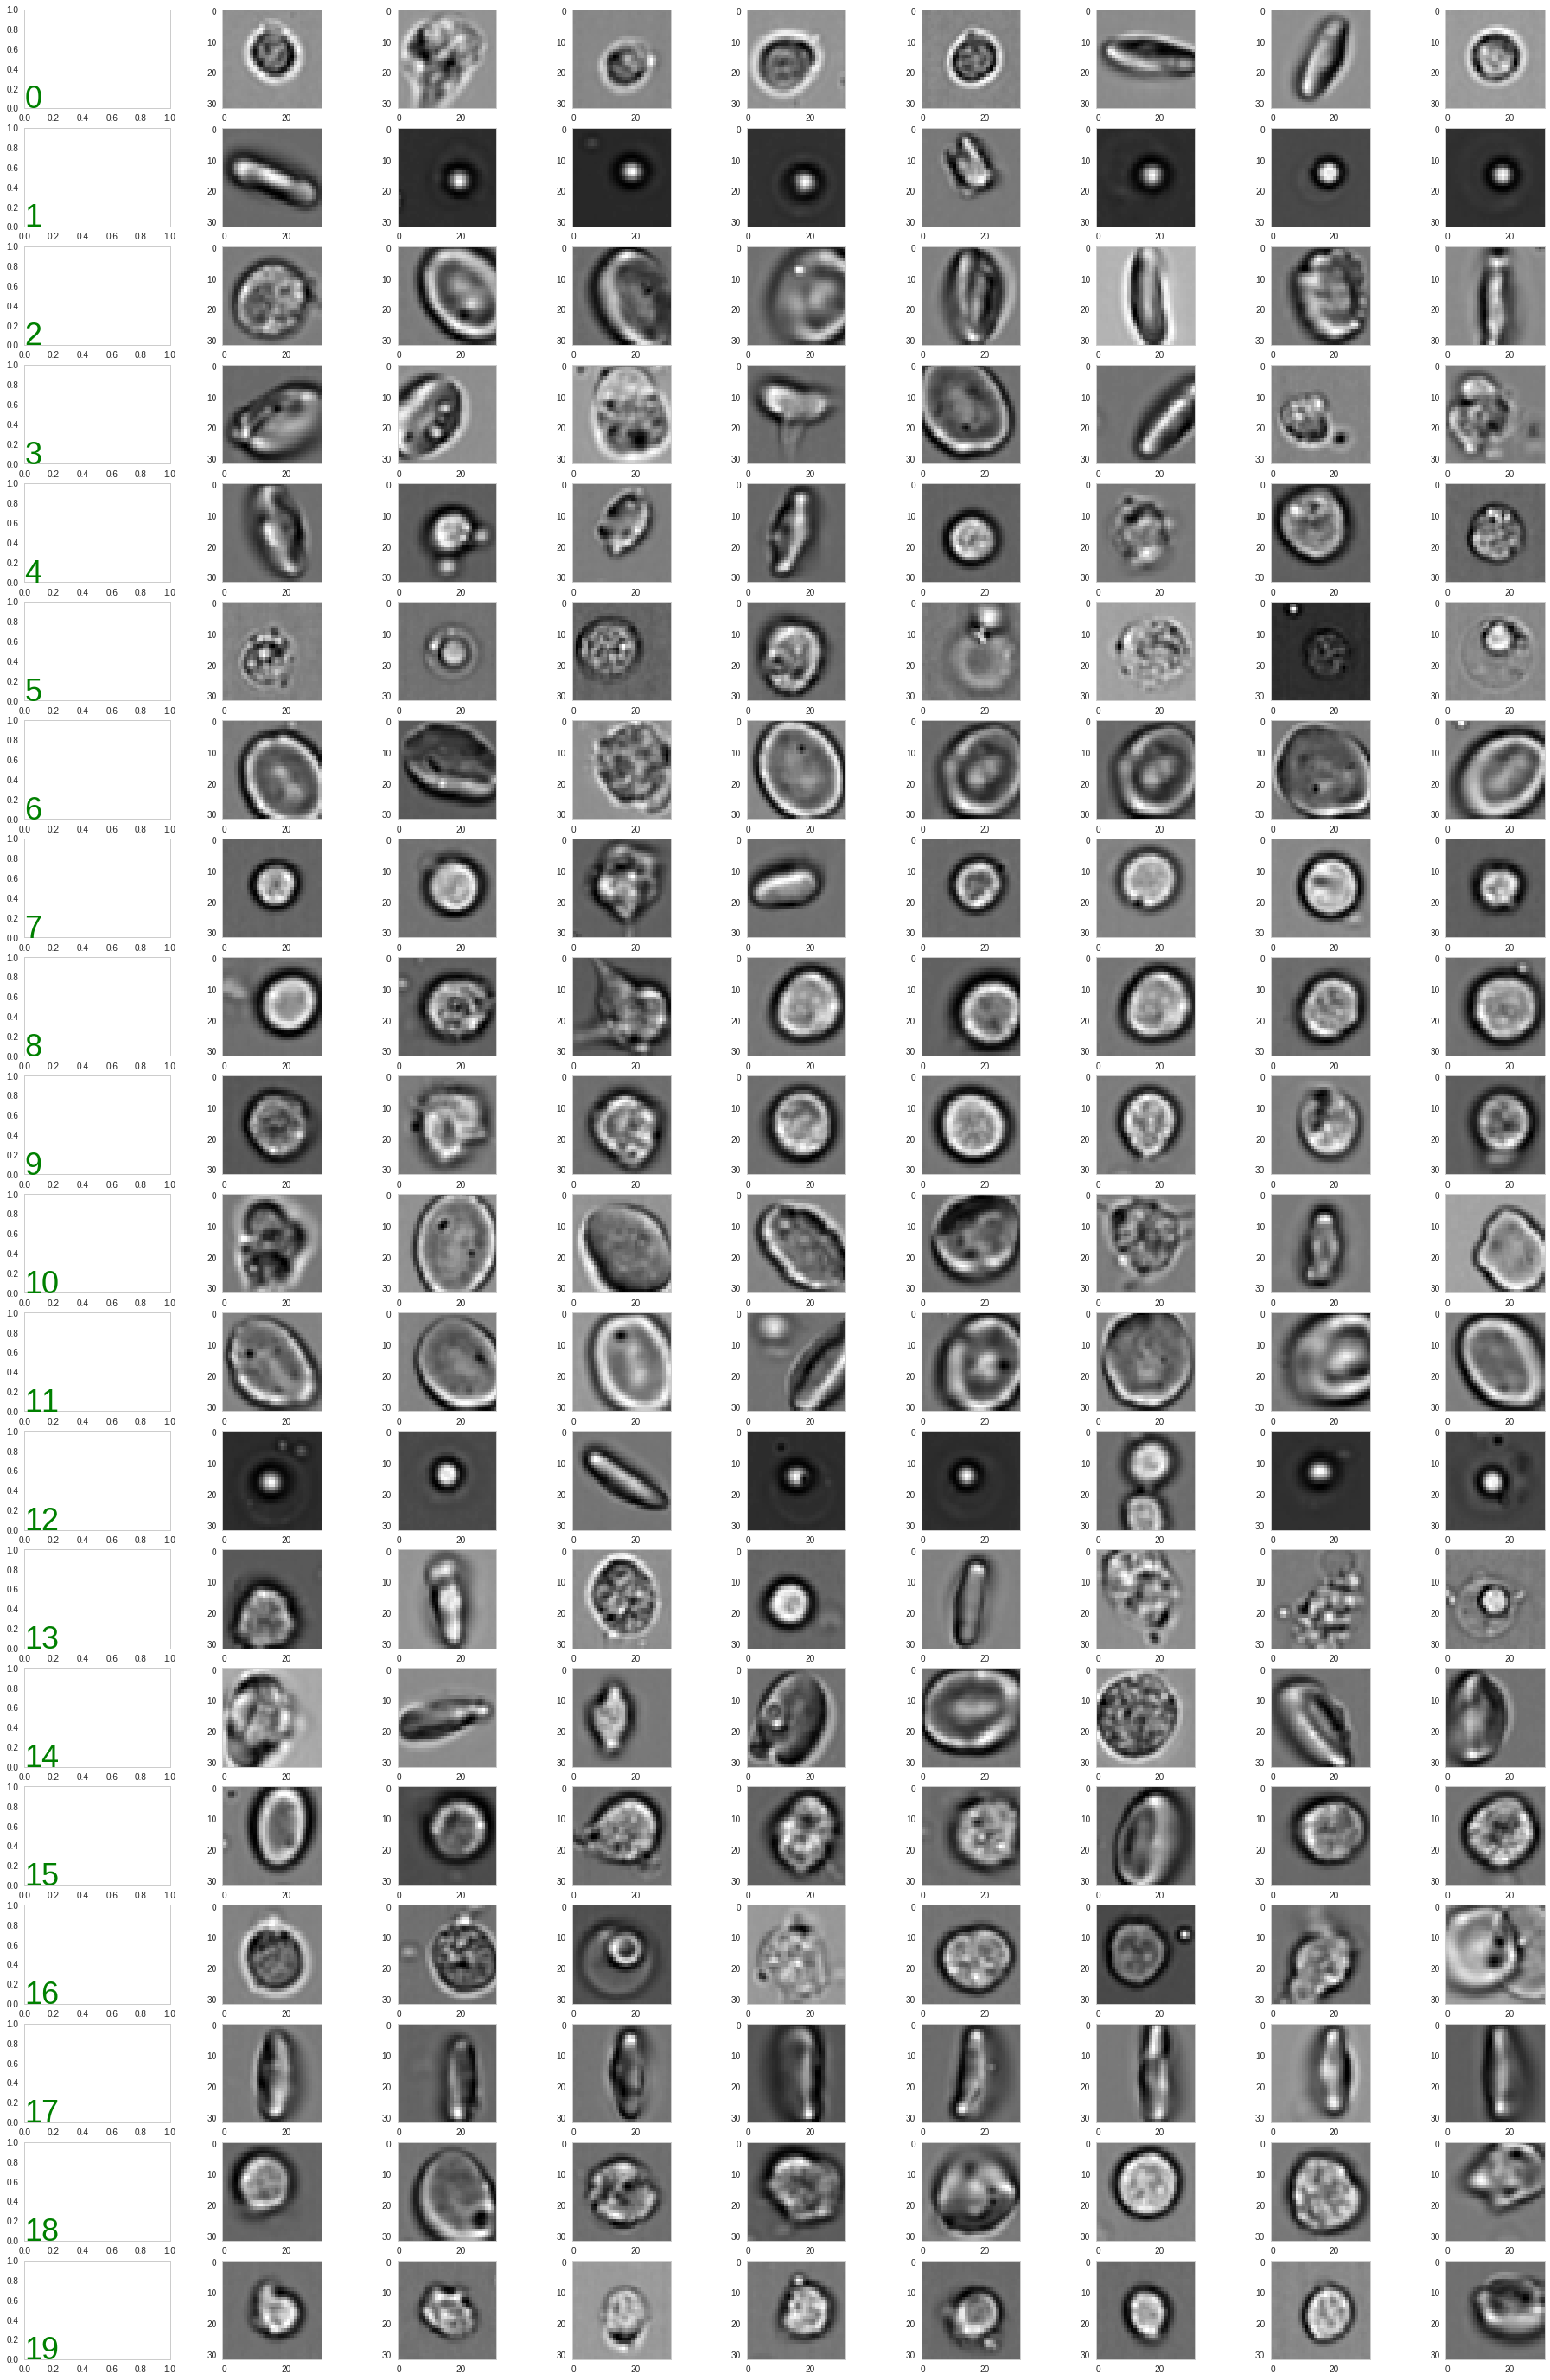

In [133]:
nk = nclust
plt.figure(figsize=(32, 2.5*n_clusters_))

counter = 1
shift = 0
for k in range(n_clusters_):
    #row = ximages[agc == k]
    rowdf = df[df['labels'] == k]
    inum = list(rowdf.index)
    print(k, len(rowdf), counter)
#     gk = g_all[agc == k]
#     gavk = np.mean(gk, axis=0)
#     gavk = np.expand_dims(gavk.squeeze(), axis=0)
#     resav = sess.run(sdd, feed_dict={enc:gavk})
    plt.subplot(n_clusters_, 9, counter)
#     plt.imshow(resav.squeeze(), cmap='gray')
    plt.text(0, 0,str(k), fontsize=36, color='green')
    counter += 1
    for i in range(8):
        plt.subplot(n_clusters_, 9, counter)
        counter += 1
        try:
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            #plt.text(8, 12,str(rnd), fontsize=24, color='white')
        except:
            plt.imshow(np.zeros((64,64)))

In [119]:
from sklearn.manifold import TSNE
g_emb4 = TSNE(n_components=2,perplexity=50, learning_rate=500).fit_transform(g4.astype(np.float64))



1 3661
9 721
2 3455
5 1254


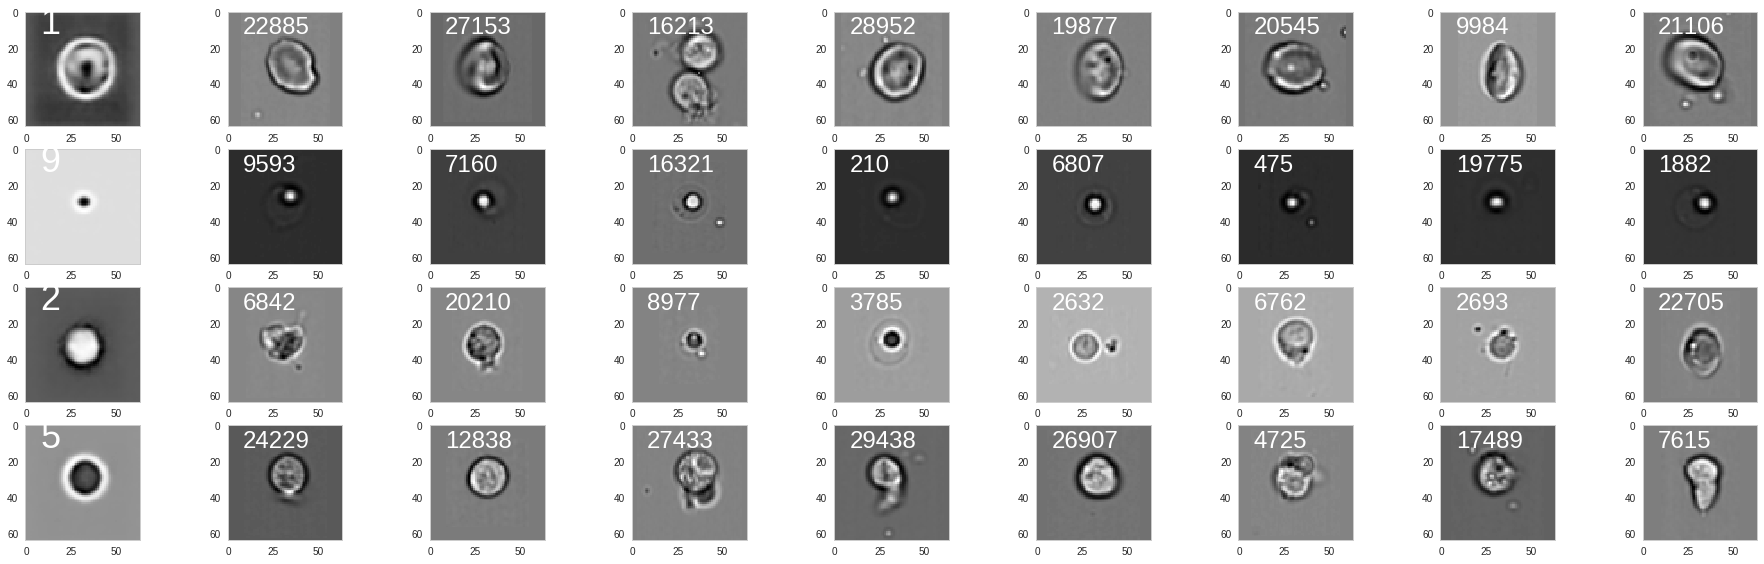

In [81]:
nk = nclust
plt.figure(figsize=(32, 2.5*nk))

counter = 1
shift = 0
for k in (1,9,2,5):
    #row = ximages[agc == k]
    rowdf = df[df['agc'] == k]
    inum = list(rowdf.index)
    print(k, len(rowdf))
    gk = g_all[agc == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
    plt.subplot(nk, 9, counter)
    plt.imshow(resav.squeeze())
    plt.text(8, 12,str(k), fontsize=36, color='white')
    counter += 1
    for i in range(8):
        plt.subplot(nk, 9, counter)
        counter += 1
        try:
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.text(8, 12,str(rnd), fontsize=24, color='white')
        except:
            plt.imshow(np.zeros((64,64)))


(1, 64, 64)
(1, 64, 64, 1)


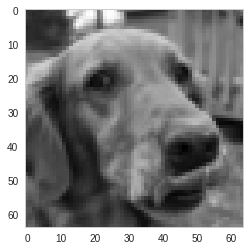

In [226]:
import skimage.io
daisyraw = skimage.io.imread("/home/cjw/disk2cjw/Data/daisy64.tif")

daisy = np.expand_dims(daisyraw, axis=0)
print(daisy.shape)
daisy = np.expand_dims(daisy, axis=-1)
mxd = np.amax(daisy)
mnd = np.amin(daisy)
daisy = (daisy - mnd)/(mxd - mnd)
daisy = daisy - np.mean(daisy) + 0.5
# daisy = np.expand_dims(daisy, axis=-1)
print(daisy.shape)
plt.imshow(daisy.squeeze(), cmap='gray')

In [227]:
de = sess.run(enc, feed_dict={images:daisy})
print(de.shape)
xr =0 + .1*np.random.randn(128)
xr[23:86] = 0
print(xr.shape)
de[0,:] = xr
dd  = sess.run(sdd, feed_dict={enc:de})

(1, 128)
(128,)


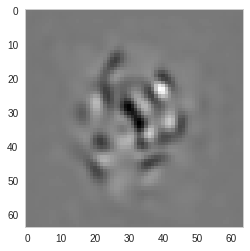

In [228]:
plt.imshow(dd.squeeze(), cmap='gray')


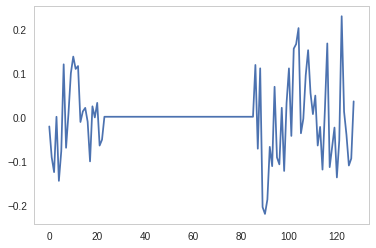

In [229]:
plt.plot(de.squeeze())